# Energy efficiency at 11 degree

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pylab as plt
import delfi.distribution as dd
import time
from copy import deepcopy
import sys
sys.path.append("../setup")
sys.path.append("../simulator")
sys.path.append("../inference")
sys.path.append("../visualization")
sys.path.append('../thesis_figs')

from common import col, svg, samples_nd
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
import viz_samples
import viz_samples_thesis
import train_utils as tu
import startEndUtils as seu
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle
from summstats_histogramms import plot_histogramm
from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs
import energy as ue

import matplotlib as mpl

date_today = '1908208'

%load_ext autoreload
%autoreload 2

### Sort out the data from the cluster

In [3]:
data_n = np.load('../results/energy/11deg_post_pred/11_deg_post_pred_close_to_obs.npz')
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print('There are', len(sample_seeds), 'datapoints in this dataset')

There are 55157 datapoints in this dataset


In [4]:
datafile = '../results/energy/classifier/prior_simulated/samples_full_2.npz'
data = np.load(datafile)

params = data['params']
stats = data['stats']
seeds = data['seeds']

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

### Load setup

In [5]:
params_11 = netio.load_setup('collect_31D')

In [6]:
prior_11 = netio.create_prior(params_11, log=True)
dimensions_11 = np.sum(params_11.use_membrane) + 7
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T

labels_ = viz.get_labels(params_11)
prior_normalized = dd.Uniform(-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11), seed=params_11.seed)

params_11 = deepcopy(params_11)

params_mean_11 = prior_11.mean
params_std_11 = prior_11.std

params_11.model_params['temp'] = 283
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

('seed in cHH', None)


In [7]:
sample_params = (sample_params - params_mean_11) / params_std_11

In [8]:
npz = np.load('../results/experimental/traces/857_016/data_857_016_0056.npz')
t_15 = npz['t']

dt = t_15[1] - t_15[0]

# Plot posterior at 11 degree (after rejection sampling)

In [9]:
labels_ = viz.get_labels_8pt(params_11)
labels_[9] += ''

In [10]:
from decimal import Decimal
all_labels = []
lims=lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$     ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$  ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$  ')
            counter+=1
        all_labels.append(new_labels)

# Summary plot

### Extract energies for the very very lowest in total

In [11]:
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]

In [12]:
max_energy_allowed = 1367000
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)
sample_params_total = sample_params[summed_energies < max_energy_allowed]
sample_stats_total = sample_stats[summed_energies < max_energy_allowed]
sample_seeds_total = sample_seeds[summed_energies < max_energy_allowed]
print(sample_seeds_total.shape)

(100,)


In [13]:
energies_all_ABPD = sample_stats_total[:, 21]
energies_all_LP = sample_stats_total[:, 22]
energies_all_PY = sample_stats_total[:, 23]
energies_all_total = np.sum(sample_stats_total[:, 21:24], axis=1)

In [14]:
energies_all_ABPD = sample_stats[:, 21]
energies_all_LP = sample_stats[:, 22]
energies_all_PY = sample_stats[:, 23]
energies_all_total = np.sum(sample_stats[:, 21:24], axis=1)

### Extract energies for very very lowest AB/PD energies

In [15]:
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]

In [16]:
max_energy_allowed = 136900
energies = sample_stats[:, 21:24]
summed_energies = energies[:, 0]
sample_params_ABPD = sample_params[summed_energies < max_energy_allowed]
sample_stats_ABPD = sample_stats[summed_energies < max_energy_allowed]
sample_seeds_ABPD = sample_seeds[summed_energies < max_energy_allowed]
sample_seeds_ABPD.shape

(100,)

In [17]:
energies_ABPD_ABPD = sample_stats_ABPD[:, 21]
energies_ABPD_LP = sample_stats_ABPD[:, 22]
energies_ABPD_PY = sample_stats_ABPD[:, 23]
energies_ABPD_total = np.sum(sample_stats_ABPD[:, 21:24], axis=1)

### Extract energies for very very lowest LP energies

In [18]:
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]

In [19]:
max_energy_allowed = 102100
energies = sample_stats[:, 21:24]
summed_energies = energies[:, 1]
sample_params_LP = sample_params[summed_energies < max_energy_allowed]
sample_stats_LP = sample_stats[summed_energies < max_energy_allowed]
sample_seeds_LP = sample_seeds[summed_energies < max_energy_allowed]
sample_seeds_LP.shape

(100,)

In [20]:
energies_LP_ABPD = sample_stats_LP[:, 21]
energies_LP_LP = sample_stats_LP[:, 22]
energies_LP_PY = sample_stats_LP[:, 23]
energies_LP_total = np.sum(sample_stats_LP[:, 21:24], axis=1)

### Extract energies for very very lowest PY energies

In [21]:
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]

In [22]:
max_energy_allowed = 392000
energies = sample_stats[:, 21:24]
summed_energies = energies[:, 2]
sample_params_PY = sample_params[summed_energies < max_energy_allowed]
sample_stats_PY = sample_stats[summed_energies < max_energy_allowed]
sample_seeds_PY = sample_seeds[summed_energies < max_energy_allowed]
sample_seeds_PY.shape

(100,)

In [23]:
energies_PY_ABPD = sample_stats_PY[:, 21]
energies_PY_LP = sample_stats_PY[:, 22]
energies_PY_PY = sample_stats_PY[:, 23]
energies_PY_total = np.sum(sample_stats_PY[:, 21:24], axis=1)

# Test for statistical independence

In [24]:
energies.shape

(55157, 3)

In [25]:
a = np.random.randn(1000,2)

In [26]:
np.corrcoef(energies[:1000,0], energies[:1000,1])[0,1]

-0.0013229906433896896

In [27]:
np.corrcoef(energies[:1000,0], energies[:1000,2])[0,1]

0.0065916302674175874

In [28]:
np.corrcoef(energies[:1000,1], energies[:1000,2])[0,1]

0.02413069807432013

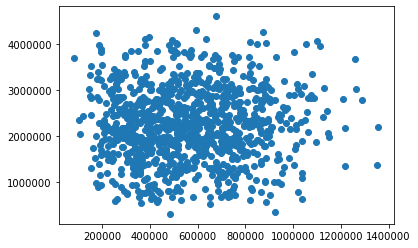

In [29]:
plt.scatter(energies[:1000,1], energies[:1000,2])

### Plot the boxplot for the first time

In [24]:
a = np.asarray([1, 2, 3, 4])
positions = np.concatenate((a, a+6, a+12, a+18))

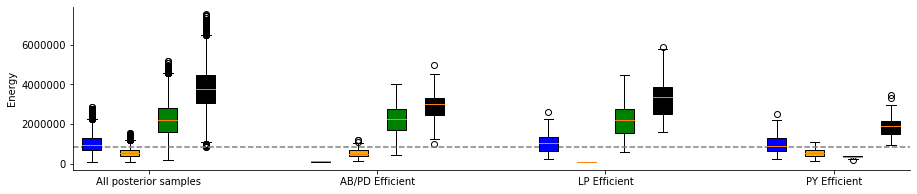

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (15, 3))

box1 = ax.boxplot([energies_all_ABPD, energies_all_LP, energies_all_PY, energies_all_total,
                    energies_ABPD_ABPD, energies_ABPD_LP, energies_ABPD_PY, energies_ABPD_total,
                    energies_LP_ABPD, energies_LP_LP, energies_LP_PY, energies_LP_total, 
                    energies_PY_ABPD, energies_PY_LP, energies_PY_PY, energies_PY_total, ], positions=positions, patch_artist=True)

cols = ['b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k']

for i, patch in enumerate(box1['boxes']):
    patch.set(facecolor=cols[i])

ax.axhline(np.min(energies_all_total), linestyle='--', color='grey')

_ = ax.set_ylabel('Energy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([2.5, 8.5, 14.5, 20.5])
ax.set_xticklabels(['All posterior samples', 'AB/PD Efficient', 'LP Efficient', 'PY Efficient'])

plt.savefig('../results/energy/figs_new/boxplot_figure_allPosteriorSamples_noComposition.png', dpi=300, bbox_inches='tight')

### Add the ones that are built by independent composition

In [26]:
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)
pyloric_sim = pyloric_sim_11
summ_stats = energy_calc

('seed in cHH', None)


In [27]:
npz = np.load('../results/experimental/summstats/845_082/190807_summstats_prep845_082_0044.npz')
observation = npz['summ_stats']

In [28]:
all_targets = []
all_counter = 0
offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]
scale_bar_ = [False, False]

good_ss = []
all_good_energies = []
all_good_energies_ABPD = []
all_good_energies_LP = []
all_good_energies_PY = []

perfect_params = []
perfect_ss = []

perfect_params_times10 = []
perfect_ss_times10 = []

for _ in range(1000):
    ABPD_index = np.random.randint(0, 100, 1)[0] # 100 cause 100 lowest energy samples
    LP_index   = np.random.randint(0, 100, 1)[0] # 100 cause 100 lowest energy samples
    PY_index   = np.random.randint(0, 100, 1)[0] # 100 cause 100 lowest energy samples
    
    syn_index = np.random.randint(0, 3, 1)
    
    if syn_index[0] == 0:
        syn_params = sample_params_ABPD[ABPD_index, 24:]
    if syn_index[0] == 1:
        syn_params = sample_params_LP[LP_index, 24:]
    if syn_index[0] == 2:
        syn_params = sample_params_PY[PY_index, 24:]
        
    comb_params = np.concatenate((sample_params_ABPD[ABPD_index, :8], sample_params_LP[LP_index, 8:16], sample_params_PY[PY_index, 16:24], syn_params))
    
    target_params = deepcopy(comb_params)
    if all_counter % 50 == 0: print('all_counter', all_counter)

    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0) # params.true_params gives the synaptic strengths  # 165000    
    
    ss = energy_calc.calc([out_target])
    
    if np.invert(np.any(np.isnan(ss))):
        all_good_energies_ABPD.append(np.sum(out_target['energy'], axis=1)[0])
        all_good_energies_LP.append(np.sum(out_target['energy'], axis=1)[1])
        all_good_energies_PY.append(np.sum(out_target['energy'], axis=1)[2])
        all_good_energies.append(np.sum(out_target['energy']))
        good_ss.append(ss[0])
        
        num_std = np.asarray([0.02, 0.02, 0.02, 0.02, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])
        response = ue.check_if_close_to_obs(ss[0], observation, num_std, stats_std=stats_std)
        if response:
            perfect_params.append(target_params)
            perfect_ss.append(ss[0])
            
        num_std = np.asarray([0.02, 0.02, 0.02, 0.02, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])*5
        response = ue.check_if_close_to_obs(ss[0], observation, num_std, stats_std=stats_std)
        if response:
            perfect_params_times10.append(target_params)
            perfect_ss_times10.append(ss[0])
        
    all_counter += 1
    
good_ss = np.asarray(good_ss)
perfect_params = np.asarray(perfect_params)
perfect_ss = np.asarray(perfect_ss)
perfect_params_times10 = np.asarray(perfect_params_times10)
perfect_ss_times10 = np.asarray(perfect_ss_times10)

all_counter 0


/Users/deismic/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/deismic/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deismic/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


all_counter 50
all_counter 100
all_counter 150
all_counter 200
all_counter 250
all_counter 300
all_counter 350
all_counter 400


KeyboardInterrupt: 

In [82]:
good_ss.shape

(573, 46)

In [83]:
perfect_ss_times10.shape

(140, 46)

In [84]:
perfect_params.shape

(1, 31)

### Plot the full boxplot

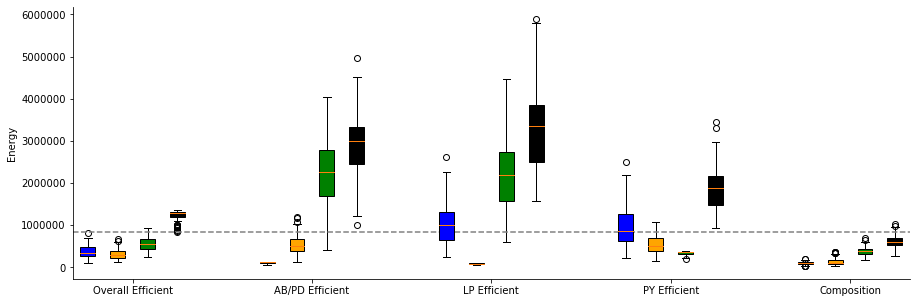

In [78]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

a = np.asarray([1, 2, 3, 4])
positions = np.concatenate((a, a+6, a+12, a+18, a+24))

box1 = ax.boxplot([energies_all_ABPD, energies_all_LP, energies_all_PY, energies_all_total,
                    energies_ABPD_ABPD, energies_ABPD_LP, energies_ABPD_PY, energies_ABPD_total,
                    energies_LP_ABPD, energies_LP_LP, energies_LP_PY, energies_LP_total, 
                    energies_PY_ABPD, energies_PY_LP, energies_PY_PY, energies_PY_total,
                    all_good_energies_ABPD, all_good_energies_LP, all_good_energies_PY, all_good_energies,], positions=positions, patch_artist=True)

cols = ['b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k', 'b', 'orange', 'g', 'k']

for i, patch in enumerate(box1['boxes']):
    patch.set(facecolor=cols[i])

ax.axhline(np.min(energies_all_total), linestyle='--', color='grey')

_ = ax.set_ylabel('Energy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([2.5, 8.5, 14.5, 20.5, 26.5])
ax.set_xticklabels(['Overall Efficient', 'AB/PD Efficient', 'LP Efficient', 'PY Efficient', 'Composition'])

#plt.savefig('../results/energy/figs_new/boxplot_figure.png', dpi=300, bbox_inches='tight')

### Inspect the parameter set that was close to experimental data and also efficient

In [43]:
all_targets = []
all_outs = []

for index, goodBad in enumerate(all_of_them):
    if goodBad:
        sample_params = deepcopy(good_targets[index]['params'])

        scale_bar_ = [False, False]
        target_params = deepcopy(sample_params)

        target_params[-7:] = np.log(target_params[-7:])
        
        for myseed in range(1):
            out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=myseed) # params.true_params gives the synaptic strengths  # 165000
            ss = energy_calc.calc([out_target])
            print('Total energy required: ', np.sum(out_target['energy']))

            val = 1.0

            experimental_stds = np.asarray( [279, 133, 113, 150, 109, 60, 169, 216, 0.040, 0.059, 0.054, 0.065, 0.034, 0.054, 0.060])
            overall = True
            for s, em, es in zip(ss[0], summstats_experimental_11, experimental_stds):
                if s < em - val*es or s > em + val*es:
                    overall = False
            print(overall)
            
            all_outs.append(out_target)

Total energy required:  448289.33542213007
True
Total energy required:  432367.44057319773
False


(13,)
(13,)


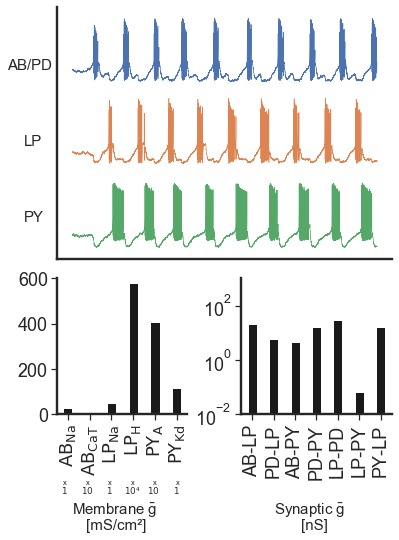

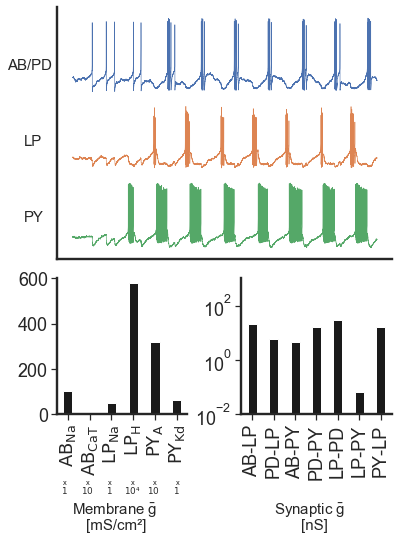

In [44]:
counter = 0
offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]
for out_target in all_outs:
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=None, fontscale=1.2, linescale=1.2, legend=False, offset=200000,
                             mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
plt.show()
counter += 1

In [38]:
posterior = inf_SNPE_MAF_11.predict(summstats_experimental_11)
all_probs_energy = []
for index, goodBad in enumerate(all_of_them):
    if goodBad:
        sample_params = deepcopy(good_targets[index]['params'])
        sample_params[-7:] = np.log(sample_params[-7:])
        sample_params = (sample_params - params_mean) / params_std
        print(sample_params)
        prob_of_energy_efficient = posterior.eval(sample_params)
        all_probs_energy.append(prob_of_energy_efficient)

[-1.52615559 -1.5838238  -1.09307575 -1.67579889  0.48628429 -0.0521258
  0.77022016  1.40292454 -0.83169335 -1.09968221 -1.6804862  -1.34117365
 -1.38524699  1.11227274  1.60825408 -0.27168274 -1.35160899 -1.13898695
  0.96195447 -0.50845969 -1.56964982  0.51741034 -0.92662495  0.35994694
  0.2940917   0.33270904  0.24025624  0.63785559  0.80533445 -1.01652765
  0.64418244]
[-1.01322579 -1.68206024  0.12703404 -0.57885408  1.53192019  0.89353317
 -1.12723494  0.11212417 -0.83169335 -1.09968221 -1.6804862  -1.34117365
 -1.38524699  1.11227274  1.60825408 -0.27168274 -1.27446818 -1.27287793
  1.17101729 -1.53403223 -0.53968799 -1.28692317 -0.68182409  1.32895005
  0.2940917   0.33270904  0.24025624  0.63785559  0.80533445 -1.01652765
  0.64418244]


In [39]:
all_probs_energy

[-33.89714483208876, -33.13582766838294]

In [40]:
posterior_samples = posterior.gen(10000)
sample_probs = posterior.eval(posterior_samples)

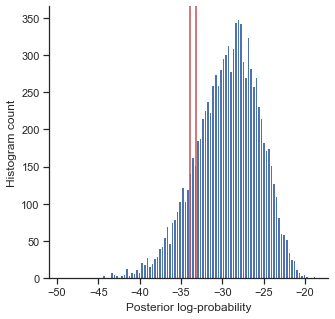

In [42]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = ax.hist(sample_probs, bins=100)
for prob in all_probs_energy: ax.axvline(prob, color='r')
ax.set_ylabel('Histogram count')
ax.set_xlabel('Posterior log-probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('../results/energy/figs/histogram_over_posterior_probs_and_composed_sample.png', dpi=300, bbox_inches='tight')

In [78]:
all_targets = 0

In [79]:
np.save('200310_mostEfficientSamples.npy', good_targets[-1])

### Simulate most efficient samples of posterior samples

In [58]:
sample_params = data_n["params"]
sample_stats = data_n["stats"]
sample_seeds = data_n["seeds"]

In [59]:
max_energy_allowed = 1141000
energies = sample_stats[:, -3:]
summed_energies = np.sum(energies, axis=1)
sample_params_total = sample_params[summed_energies < max_energy_allowed]
sample_stats_total = sample_stats[summed_energies < max_energy_allowed]
sample_seeds_total = sample_seeds[summed_energies < max_energy_allowed]
print(sample_seeds_total.shape)

(100,)


In [60]:
all_targets = []

scale_bar_ = [False, False]
target_params = deepcopy(sample_params_total[1])

for myseed in range(1):
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=myseed) # params.true_params gives the synaptic strengths  # 165000
    ss = energy_calc.calc([out_target])
    print('Total energy required: ', np.sum(out_target['energy']))

    val = 1.0

    experimental_stds = np.asarray( [279, 133, 113, 150, 109, 60, 169, 216, 0.040, 0.059, 0.054, 0.065, 0.034, 0.054, 0.060])
    overall = True
    for s, em, es in zip(ss[0], summstats_experimental_11, experimental_stds):
        if s < em - val*es or s > em + val*es:
            overall = False
    print(overall)

Total energy required:  810052.4071776284
True


(13,)


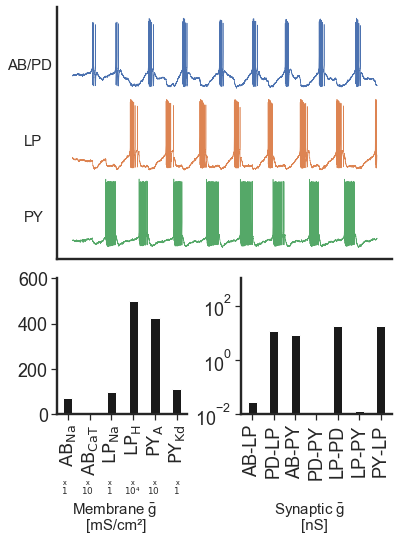

In [61]:
counter = 0
offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]
fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=None, fontscale=1.2, linescale=1.2, legend=False, offset=200000,
                             mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
plt.show()
counter += 1